# 6.1 Introduction to Classification Trees

# Classification Trees in Python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc, r2_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn import tree

from pydotplus import graph_from_dot_data

# Generate a unique color
def generate_unique_color():
    color = "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
    return color

df = pd.read_csv('healthcare_analytics.csv')
df.head()

,case id,hospital code,hospital type code,city code hospital,hospital region code,available extra rooms in hospital,department,ward type,ward facility code,bed grade,patientid,city code patient,type of admission,severity of illness,visitors with patient,age,admission deposit,health score,stay time,stay class
0,90345,26,b,2,Y,3,gynecology,Q,D,3.0,231,1.0,trauma,moderate,12,56,3152,34,85.0,long
1,15477,29,a,4,X,4,gynecology,R,F,3.0,77514,8.0,trauma,moderate,2,37,5106,43,47.0,medium
2,52839,26,b,2,Y,6,gynecology,Q,D,3.0,60762,8.0,trauma,extreme,2,23,4819,60,17.0,short
3,17057,31,c,3,Z,3,radiotherapy,Q,A,2.0,14235,1.0,emergency,moderate,3,50,6590,55,36.0,medium
4,198733,22,g,9,Y,2,gynecology,S,B,2.0,103467,8.0,urgent,moderate,4,59,5485,43,76.0,long


# **Preprocessing**

- ## Missing Data Handling

In [2]:
df.isna().sum(axis=0)

case id                                 0
hospital code                           0
hospital type code                      0
city code hospital                      0
hospital region code                    0
available extra rooms in hospital       0
department                              0
ward type                               0
ward facility code                      0
bed grade                             113
patientid                               0
city code patient                    4532
type of admission                       0
severity of illness                     0
visitors with patient                   0
age                                     0
admission deposit                       0
health score                            0
stay time                               0
stay class                              0
dtype: int64

In [3]:
df = df.dropna()

- ## Outlier Detection

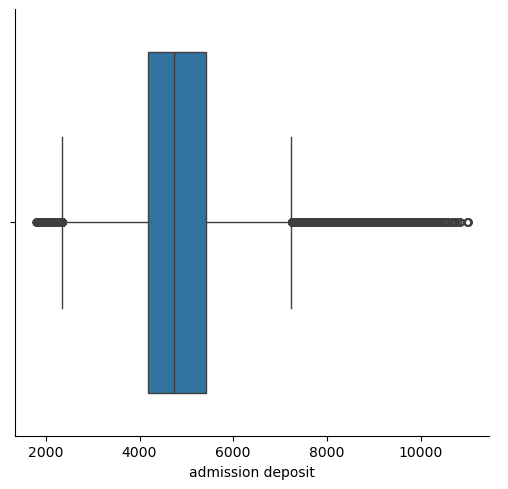

In [4]:
sns.catplot(data=df, x='admission deposit', kind='box')
plt.show()

In [5]:
df_clean = df.copy()
var_list = ['age', 'admission deposit', 'health score']

for var in var_list:
    iqr = df_clean[var].quantile(0.75) - df_clean[var].quantile(0.25)
    if not np.isnan(iqr):
        ub = df_clean[var].quantile(0.75) + 1.5 * iqr
        lb = df_clean[var].quantile(0.25) - 1.5 * iqr
        df_clean = df_clean[(df_clean[var] >= lb) & (df_clean[var] <= ub)]

print(df.shape)        
print(df_clean.shape)

(313793, 20)
(300648, 20)


- ## Dummy Encoding

In [6]:
cats = ['hospital type code', 'hospital region code', 'department', 'ward type', 'ward facility code', 'type of admission', 'severity of illness']
df1 = pd.get_dummies(df_clean, columns=cats, prefix_sep=' ', drop_first=True)
df1.head()

,case id,hospital code,city code hospital,available extra rooms in hospital,bed grade,patientid,city code patient,visitors with patient,age,admission deposit,health score,stay time,stay class,hospital type code b,hospital type code c,hospital type code d,hospital type code e,hospital type code f,hospital type code g,hospital region code Y,hospital region code Z,department gynecology,department radiotherapy,department surgery,department tb chest disease,ward type Q,ward type R,ward type S,ward type T,ward type U,ward facility code B,ward facility code C,ward facility code D,ward facility code E,ward facility code F,type of admission trauma,type of admission urgent,severity of illness minor,severity of illness moderate
0,90345,26,2,3,3.0,231,1.0,12,56,3152,34,85.0,long,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1,15477,29,4,4,3.0,77514,8.0,2,37,5106,43,47.0,medium,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
2,52839,26,2,6,3.0,60762,8.0,2,23,4819,60,17.0,short,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,17057,31,3,3,2.0,14235,1.0,3,50,6590,55,36.0,medium,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,198733,22,9,2,2.0,103467,8.0,4,59,5485,43,76.0,long,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1


In [7]:
df1.columns

Index(['case id', 'hospital code', 'city code hospital',
       'available extra rooms in hospital', 'bed grade', 'patientid',
       'city code patient', 'visitors with patient', 'age',
       'admission deposit', 'health score', 'stay time', 'stay class',
       'hospital type code b', 'hospital type code c', 'hospital type code d',
       'hospital type code e', 'hospital type code f', 'hospital type code g',
       'hospital region code Y', 'hospital region code Z',
       'department gynecology', 'department radiotherapy',
       'department surgery', 'department tb chest disease', 'ward type Q',
       'ward type R', 'ward type S', 'ward type T', 'ward type U',
       'ward facility code B', 'ward facility code C', 'ward facility code D',
       'ward facility code E', 'ward facility code F',
       'type of admission trauma', 'type of admission urgent',
       'severity of illness minor', 'severity of illness moderate'],
      dtype='object')

- ## Partitioning

In [8]:
var_list = ['available extra rooms in hospital', 'bed grade', 'visitors with patient', 'age',
               'admission deposit', 'health score', 'hospital type code b', 'hospital type code c', 'hospital type code d',
               'hospital type code e', 'hospital type code f', 'hospital type code g',
               'hospital region code Y', 'hospital region code Z',
               'department gynecology', 'department radiotherapy',
               'department surgery', 'department tb chest disease', 'ward type Q',
               'ward type R', 'ward type S', 'ward type T', 'ward type U',
               'ward facility code B', 'ward facility code C', 'ward facility code D',
               'ward facility code E', 'ward facility code F',
               'type of admission trauma', 'type of admission urgent',
               'severity of illness minor', 'severity of illness moderate']

X = df1[var_list]
y = df1['stay class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# **Modeling**

- ## Training a Classification Tree
(Pruning the Tree) 

In [10]:
# ways of pruning classification tree: dec_tree = tree.DecisionTreeClassifier(min_samples_split=5000, max_leaf_nodes=10, ccp_alpha=0.005) can be used to set restrictions on the splits of the data
dec_tree = tree.DecisionTreeClassifier(ccp_alpha=0.005, class_weight='balanced') # class_weight = 'balanced' - balances out each class
dec_tree.fit(X_train, y_train)

# Predict
y_train_hat = dec_tree.predict(X_train)

print('train accuracy:', "{:.2f}%".format(accuracy_score(y_train, y_train_hat)*100))

train accuracy: 72.20%


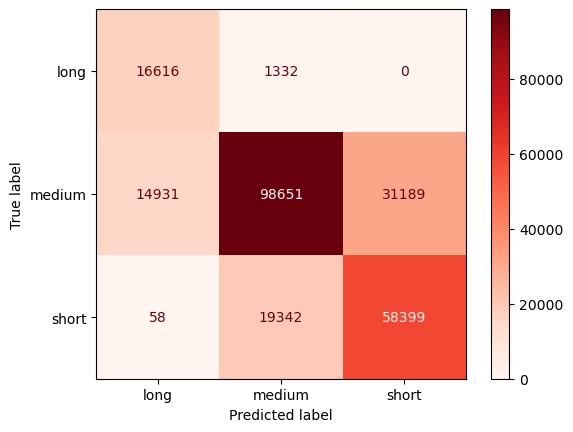

In [11]:
ConfusionMatrixDisplay.from_estimator(dec_tree, X_train, y_train, cmap=plt.cm.Reds)
plt.show()

In [12]:
print(classification_report(y_train, y_train_hat))

              precision    recall  f1-score   support

        long       0.53      0.93      0.67     17948
      medium       0.83      0.68      0.75    144771
       short       0.65      0.75      0.70     77799

    accuracy                           0.72    240518
   macro avg       0.67      0.79      0.71    240518
weighted avg       0.75      0.72      0.73    240518



In [13]:
df1.groupby(by=['stay class']).size()

stay class
long       22452
medium    180991
short      97205
dtype: int64

- ## Visualize the Tree

In [14]:
text_representation = tree.export_text(dec_tree, feature_names=var_list)
print(text_representation)

|--- age <= 50.50
|   |--- health score <= 46.50
|   |   |--- age <= 45.50
|   |   |   |--- class: medium
|   |   |--- age >  45.50
|   |   |   |--- class: medium
|   |--- health score >  46.50
|   |   |--- age <= 41.50
|   |   |   |--- class: short
|   |   |--- age >  41.50
|   |   |   |--- class: medium
|--- age >  50.50
|   |--- health score <= 44.50
|   |   |--- visitors with patient <= 3.50
|   |   |   |--- class: long
|   |   |--- visitors with patient >  3.50
|   |   |   |--- class: long
|   |--- health score >  44.50
|   |   |--- class: medium



In [15]:
dot_data = tree.export_graphviz(dec_tree, feature_names=var_list, class_names=['long', 'medium', 'short'], rounded=True, filled=True)
graph = graph_from_dot_data(dot_data)
graph.write_pdf('tree.pdf')

InvocationException: Program terminated with status: 1. stderr follows: Warning: Could not load "C:\Users\Chaye\anaconda3\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.
Warning: Could not load "C:\Users\Chaye\anaconda3\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.
Format: "pdf" not recognized. Use one of: bmp canon cmap cmapx cmapx_np dot dot_json emf emfplus eps fig gd gd2 gif gv imap imap_np ismap jpe jpeg jpg json json0 metafile mp pdf pic plain plain-ext png pov ps ps2 svg svg_inline svgz tif tiff tk vrml webp xdot xdot1.2 xdot1.4 xdot_json


# Test the Model

In [ ]:
y_test_hat = dec_tree.predict(X_test)
print('test accuracy:', "{:.2f}%".format(accuracy_score(y_test, y_test_hat)*100))
ConfusionMatrixDisplay.from_estimator(dec_tree, X_test, y_test, cmap=plt.cm.Reds)
plt.show()

In [ ]:
print(classification_report(y_test, y_test_hat))

# Feature Importance

In [ ]:
df2 = pd.DataFrame({'Variable':var_list, 'Importance':dec_tree.feature_importances_}).sort_values(by=['Importance'], ascending=False)
df2

# 6.2 Import Packages and Read the Data

# Introduction to Regression Trees

# Regression Trees in Python

# **Modeling**

In [ ]:
var_list = ['available extra rooms in hospital', 'bed grade', 'visitors with patient', 'age',
               'admission deposit', 'health score', 'hospital type code b', 'hospital type code c', 'hospital type code d',
               'hospital type code e', 'hospital type code f', 'hospital type code g',
               'hospital region code Y', 'hospital region code Z',
               'department gynecology', 'department radiotherapy',
               'department surgery', 'department tb chest disease', 'ward type Q',
               'ward type R', 'ward type S', 'ward type T', 'ward type U',
               'ward facility code B', 'ward facility code C', 'ward facility code D',
               'ward facility code E', 'ward facility code F',
               'type of admission trauma', 'type of admission urgent',
               'severity of illness minor', 'severity of illness moderate']

X = df1[var_list]
y = df1['stay time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# ways of pruning classification tree: dec_tree = tree.DecisionTreeClassifier(min_samples_split=5000, max_leaf_nodes=10, ccp_alpha=0.005) can be used to set restrictions on the splits of the data
dec_tree = tree.DecisionTreeRegressor(max_leaf_nodes= 100, ccp_alpha=1)
dec_tree.fit(X_train, y_train)

# predict
y_train_hat = dec_tree.predict(X_train)

print('train r2:', "{:.2f}%".format(r2_score(y_train, y_train_hat)*100))
print('train MSE:', "{:.2f}%".format(mean_squared_error(y_train, y_train_hat)*100))

- ## Visualize the Tree

In [ ]:
text_representation = tree.export_text(dec_tree, feature_names=var_list)
print(text_representation)

In [ ]:
dot_data = tree.export_graphviz(dec_tree, feature_names=var_list, rounded=True, filled=True)
graph = graph_from_dot_data(dot_data)
graph.write_pdf('tree.pdf')

# Test the Model

In [ ]:
y_test_hat = dec_tree.predict(X_test)

print('test r2:', "{:.2f}%".format(r2_score(y_test, y_test_hat)*100))
print('test MSE:', "{:.2f}%".format(mean_squared_error(y_test, y_test_hat)*100))

# Feature Importance

In [ ]:
df2 = pd.DataFrame({'Variable':var_list, 'Importance':dec_tree.feature_importances_}).sort_values(by=['Importance'], ascending=False)
df2